In [7]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import c as clight
from astropy.constants import e as e_elec
from astropy.constants import h as hplanck
from astropy.cosmology import WMAP9 as cosmo

plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=20
plt.rcParams["xtick.labelsize"]=20
plt.rcParams["ytick.labelsize"]=20
plt.rcParams["legend.fontsize"]=20

In [8]:
reilog_B40F=np.loadtxt("/data/gnedin/REI/D/Cai.B40.N256L2.sf=1_uv=0.15_bw=10_res=100.WC1/F/rei.log")

In [9]:
print(1/reilog_B40F[:-2,0][-60::5]-1,reilog_B40F[:-2,1][-60::5])

[7.99280576 7.65800866 7.34028357 7.01924619 6.77000777 6.57575758
 6.3313783  6.09219858 5.88705234 5.73400673 5.55307995 5.36942675] [4.966e-17 1.003e-16 2.475e-16 1.632e-15 7.099e-15 3.477e-14 8.298e-14
 1.226e-13 1.565e-13 1.930e-13 2.630e-13 3.442e-13]


In [16]:
data_path="/data/hqchen/mfp_project/data/"

In [17]:
for z in ["5.4","6.1","6.8"]:
    gammalist=np.load(data_path+"B40F_unisample_gamma_bkg_z="+z+".npy")
    print(z,np.median(gammalist))

5.4 2.7793394365122923e-13
6.1 1.0889199446846259e-13
6.8 2.2231268932083237e-14


In [5]:
Req=18 #pMpc
xi=0.67
kapbg=10**(-24.5) #cm^-2 wrong, cm^-1

In [8]:
def kap(drArr,Req,xi,kapbg):
    """
    Calculate kappa profile given inputs.

    Parameters:
    - drArr: array of radial step sizes in pMpc
    - Req: characteristic scale in pMpc, where \Gamma_qso==\Gamma_bkg assuming pure geometric dillusion
    - xi: power-law index
    - kapbg: background opacity in 1/pMpc

    Returns:
    - kapr: array of kappa values at each radial step
    """
    rArr=np.cumsum(drArr)
    kapbg*=3.08e24 #convert to 1/pMpc
    Gq_o_Gbg=np.zeros_like(rArr)
    kapr=np.zeros_like(rArr)
    kapr[0]=0
    Gq_o_Gbg[0]=(rArr[0]/Req)**(-2) #Eq7
    for i in range(1,len(rArr)):
        kapr[i]=kapbg*(1+Gq_o_Gbg[i-1])**(-xi) #Eq4
        Gq_o_Gbg[i]=Gq_o_Gbg[i-1]*(rArr[i]/rArr[i-1])**(-2)*np.exp(-kapr[i-1]*drArr[i-1]) #Eq8
    return kapr#,Gq_o_Gbg

In [12]:
def tau_LyC(wv_rest,Req,xi,kapbg,debug=True):
    """
    Calculate LyC optical depth profile using Becker+21 model (which has 3 parameters Req,xi,kapbg).

    Parameters:
    - wv_rest: rest-frame wavelength array where LyC optical depth is calculated
    - Req: [pMpc], model parameter characterizing quasar luminosity, where \Gamma_qso==\Gamma_bkg assuming pure geometric dillusion.
    - xi: dimensionless, power-law index
    - kapbg: [1/pMpc], background opacity 

    Returns:
    - tau_eff: LyC optical depth at each wv_rest
    """
    z912=wv_rest/911.76*(1+zqso)-1
#     print(z912)
    ngrid=10000
    dzpArr=np.ones(ngrid)*(zqso-z912)/ngrid
    zpArr=z912+(np.cumsum(dzpArr)-dzpArr[0]/2)
    drArr=dzpArr/Hz*clight.to("km/s").value/(1+zqso)
#     print(np.sum(drArr))
#     print((911.76-wv_rest)/911.76*clight.to("km/s").value/Hz)
    kap_zp=kap(drArr,Req,xi,kapbg)
    
    integ=(np.sum(kap_zp*(1+zpArr)**(-5.25)*dzpArr))
    tau_eff=clight.to("km/s").value/H0/cosmo.Om0**0.5*(1+z912)**2.75*integ
#     if debug==True:
#         return drArr,kap_zp,tau_eff
    return tau_eff

def convert_mfp_kapbg(wv_rest,kapbg):
    z912=wv_rest/911.76*(1+zqso)-1
    ngrid=10000
    dzpArr=np.ones(ngrid)*(zqso-z912)/ngrid
    zpArr=z912+(np.cumsum(dzpArr)-dzpArr[0]/2)
    drArr=dzpArr/Hz*clight.to("km/s").value/(1+zqso)
    kap_zp=np.ones_like(drArr)*kapbg*3.08e24
    integ=(np.sum(kap_zp*(1+zpArr)**(-5.25)*dzpArr))
    return clight.to("km/s").value/H0/cosmo.Om0**0.5*(1+z912)**2.75*integ

### load data (no qso)
in this case, $\xi$ should be 0 because there is no quasar contribution

In [14]:
auni=0.1401
zqso=1/auni-1
print(zqso)
Hz=cosmo.H(zqso).value
H0=cosmo.H(0).value

6.137758743754461


In [18]:
wv_rest_arr=np.loadtxt(data_path+"new_AAout.txt")
tau_profiles_noqso=np.load(data_path+"new_tau_profiles_F_a{:.4f}_noq.npy".format(auni))

In [51]:
mean_p_noq=np.mean(np.exp(-tau_profiles_noqso),axis=0)
median_p_noq=np.median(np.exp(-tau_profiles_noqso),axis=0)

In [52]:
AAout=wv_rest_arr
clight_kmps=clight.to("km/s").value
mfp=clight_kmps*(911.6485294117647-AAout[np.argmin(np.abs(mean_p_noq-1/np.e))])/911.6485294117647/Hz
print("mean profile: mfp [pMpc]  =",mfp)
mfp=clight_kmps*(911.6485294117647-AAout[np.argmin(np.abs(median_p_noq-1/np.e))])/911.6485294117647/Hz
print("median profile: mfp [pMpc]=",mfp)

mean profile: mfp [pMpc]  = 5.899116704137159
median profile: mfp [pMpc]= 6.390709762815301


In [53]:
plt.rcParams["text.usetex"]=True
plt.rcParams["axes.labelsize"]=20
plt.rcParams["xtick.labelsize"]=20
plt.rcParams["ytick.labelsize"]=20
plt.rcParams["legend.fontsize"]=14
plt.rcParams["legend.title_fontsize"]=14

/data/hqchen/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


\Chi^2\propto 10.314811435226721


/data/hqchen/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


\Chi^2\propto 2.9625077701183073


/data/hqchen/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


\Chi^2\propto 0.03676101509813867


/data/hqchen/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


\Chi^2\propto 0.25899507273839434


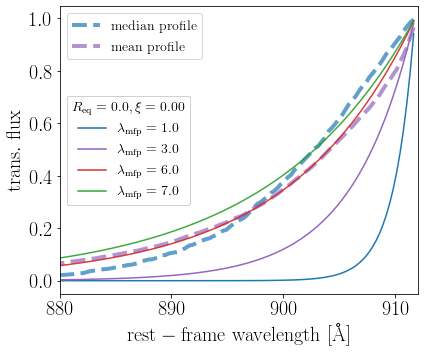

In [54]:
fig=plt.figure(figsize=(6,5)) 
axes = fig.subplots()

line1,=plt.plot(wv_rest_arr,median_p_noq,label=r"$\rm median \ profile$",lw=4,color="tab:blue",alpha=0.7,ls="--")

line2,=plt.plot(wv_rest_arr,mean_p_noq,label=r"$\rm mean \ profile$",lw=4,color="tab:purple",alpha=0.7,ls="--")
legend1 = plt.legend(handles=[line1, line2], loc='upper left')


Req=0 #pMpc
xi=0
mfp=1
kapbg=1./(mfp*3.08e24)

tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line3,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp),color="tab:blue")

print("\Chi^2\propto",np.sum((mean_p_noq-np.exp(-tau_arr))**2))


Req=0 #pMpc
xi=0
mfp=3
kapbg=1./(mfp*3.08e24)

tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line4,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp),color="tab:purple")

print("\Chi^2\propto",np.sum((mean_p_noq-np.exp(-tau_arr))**2))




mfp=6
kapbg=1./(mfp*3.08e24)
tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])
line5,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp),\
                color="tab:red",alpha=0.9)
print("\Chi^2\propto",np.sum((mean_p_noq-np.exp(-tau_arr))**2))


mfp=7
kapbg=1./(mfp*3.08e24)
tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])
line6,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp),\
                color="tab:green",alpha=0.9)

print("\Chi^2\propto",np.sum((mean_p_noq-np.exp(-tau_arr))**2))


legend2 = plt.legend(handles=[line3, line4, line5, line6], loc='center left')
legend2.set_title(r"$R_{{\rm eq}}={:3.1f},\xi={:4.2f}$".format(Req,xi))
axes.add_artist(legend1)
axes.add_artist(legend2)
plt.xlim(880,912)
plt.xlabel(r"$\rm rest-frame \  wavelength \ [\r{A}]$")
plt.ylabel(r"$\rm trans. \ flux$")
plt.tight_layout()

# plt.savefig("sim_noq_beckermodel_z64.pdf")

### load data (with qso)
in this case, $\xi$ is assumed to be 0.67 according to Becker+21 to account for quasar contribution 

In [19]:
print("z=",1/auni-1)
qso_t1e7_tau_profiles=np.load(data_path+"new_tau_profiles_F_a{:.4f}_qso_Ndot1.4e57_tQ1e7yr.npy".format(auni))

z= 6.137758743754461


In [119]:
mean_p=np.mean(np.exp(-qso_t1e7_tau_profiles),axis=0)
median_p=np.median(np.exp(-qso_t1e7_tau_profiles),axis=0)

\Chi^2\propto 0.011087422870582486
\Chi^2\propto 0.005679712578468545
\Chi^2\propto 0.03426786929135117


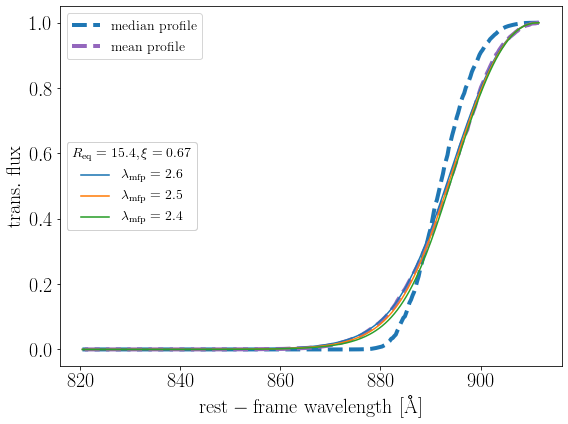

In [127]:
fig=plt.figure(figsize=(8,6)) 
axes = fig.subplots()

line1,=plt.plot(wv_rest_arr,median_p,label=r"$\rm median \ profile$",lw=4,color="tab:blue",ls="--")

line2,=plt.plot(wv_rest_arr,mean_p,label=r"$\rm mean \ profile$",lw=4,color="tab:purple",ls="--")
legend1 = plt.legend(handles=[line1, line2], loc='upper left')


Req=15.4 #pMpc
xi=0.67
mfp=2.6
kapbg=1./(mfp*3.08e24)
tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line3,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))
print("\Chi^2\propto",np.sum((mean_p-np.exp(-tau_arr))**2))



mfp=2.5
kapbg=1./(mfp*3.08e24)
tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line4,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))

print("\Chi^2\propto",np.sum((mean_p-np.exp(-tau_arr))**2))

mfp=2.4
kapbg=1./(mfp*3.08e24)

tau_arr=np.array([tau_LyC(wv,Req,xi,kapbg) for wv in wv_rest_arr])

line5,=plt.plot(wv_rest_arr,np.exp(-tau_arr),label=r"$\lambda_{{\rm mfp}}={:4.1f}$".format(mfp))
legend2 = plt.legend(handles=[line3, line4,line5], loc='center left')
legend2.set_title(r"$R_{{\rm eq}}={:3.1f},\xi={:4.2f}$".format(Req,xi))

print("\Chi^2\propto",np.sum((mean_p-np.exp(-tau_arr))**2))



axes.add_artist(legend1)
axes.add_artist(legend2)

plt.xlabel(r"$\rm rest-frame \  wavelength \ [\r{A}]$")
plt.ylabel(r"$\rm trans. \ flux$")
plt.tight_layout()

# plt.savefig("sim_beckermodel.pdf")